In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
## !! CHANGE ME !! ##
from suite2p.io import lbm as lbmio
from suite2p.suite3d import utils
from suite2p.suite3d.job import Job
from suite2p.suite3d import ui

os.chdir('/home/ali/packages/s2p-lbm/')
from utils import tiff_utils as tfu
from utils import file_utils as flu

In [14]:
from mkl_fft import fftn, ifftn
import cupy as cp
import cupyx.scipy.fft as cufft
import scipy.fft

In [3]:
# Create the job
job = Job('/mnt/md0/runs','AH007_2022-03-28_2-4-5', create=False, overwrite=False, verbosity = 10)

   Found and loaded params from /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/params.npy


In [4]:
tifs, si_params, exp_str = flu.find_exp(job.params['subjects_dir'], job.params['subject'],
                                        job.params['date'], job.params['expnum'])

SI ROI pix count in x is 182, which is impossible, setting it to 145


In [5]:
exp_dir = flu.find_expt_file((job.params['subject'], job.params['date'], job.params['expnum'][0]),
                         'root', dirs=[job.params['subjects_dir']])

In [6]:
offset_files = job.get_registered_files('registered_data', 'offset')

In [7]:
cz = (0,20)
ct = (0, 10)
cy = (None,None)
cx = (None,None)

In [8]:
mov_reg = job.get_registered_movie()[cz[0]:cz[1],ct[0]:ct[1], cy[0]:cy[1], cx[0]:cx[1]].compute()

In [9]:
mov_raw = lbmio.load_and_stitch_tifs(job.tifs[:2], planes = n.arange(cz[0],cz[1]))[:,:,cy[0]:cy[1], cx[0]:cx[1]]
mov_raw = mov_raw[:,ct[0]:ct[1]]

Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif
Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00001.tif
Loaded 2 files, total 5.73 GB


In [10]:
offsets = [n.load(f,allow_pickle=True).item() for f in offset_files]
offset = offsets[0]
for k,v in offset.items():
    offset[k] = n.array(n.concatenate([o[k] for o in offsets],axis=1) )
    offset[k] = offset[k][cz[0]:cz[1], ct[0]:ct[1]]
dx = (offset['xms'] - n.floor(offset['xms'].mean(axis=1,keepdims=True)))[cz[0]:cz[1]]
dy = (offset['yms'] - n.floor(offset['yms'].mean(axis=1,keepdims=True)))[cz[0]:cz[1]]

In [41]:
summary = job.load_summary()
refs_and_masks = summary['refs_and_masks']
mask_mul, mask_offset, ref_2ds = n.stack([r[:3] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
mask_mul_nr, mask_offset_nr, ref_nr = n.stack([r[3:] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]

In [46]:
ref_real.shape

(30, 1202, 1015)

In [58]:
ref_real = summary['ref_img_3d'][cz[0]:cz[1]]

In [59]:
all_ops = summary['all_ops']
ops = all_ops[0]

max_shift_xy = 50
max_shift_z = 5

In [60]:
mov = mov_raw.copy().swapaxes(0,1).astype(n.float32)

In [89]:
nt = mov.shape[0]

In [61]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [62]:
%%time
mov_gpu = cp.asarray(mov, dtype=n.float32)
mul_mask_gpu = cp.asarray(mask_mul.real)
off_mask_gpu = cp.asarray(mask_offset.real)
ref_gpu = cp.asarray(ref_real)

CPU times: user 287 ms, sys: 159 ms, total: 446 ms
Wall time: 446 ms


In [209]:
ref_gpu_2d_f = cp.conj(cufft.fftn(ref_gpu, axes=(1,2)))
ref_gpu_2d_f /= cp.abs(ref_gpu_2d_f)

ref_gpu_f = cp.conj(cufft.fftn(ref_gpu, axes=(0,1,2)))
ref_gpu_f /= cp.abs(ref_gpu_f)

In [210]:
%%time
for zidx in range(*cz):
    mov_gpu[:,zidx] = cp.clip(mov_gpu[:,zidx], (all_ops[zidx]['rmin']), (all_ops[zidx]['rmax']))
mov_gpu *= mul_mask_gpu[cp.newaxis] 
mov_gpu += off_mask_gpu[cp.newaxis]
mov_gpu_f = cufft.fftn(mov_gpu, axes=(2,3))

CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 23 ms


In [94]:
%%time
mov_gpu_f /= (cp.complex64(1e-5) + cp.abs(mov_gpu_f))
mov_gpu_f *= ref_gpu_f[cp.newaxis]
mov_gpu_f = mov_gpu_f.real

CPU times: user 184 µs, sys: 117 µs, total: 301 µs
Wall time: 288 µs


In [124]:
%%time
mov_gpu_f_concat = n.concatenate((mov_gpu_f[:,:,-max_shift_xy:], mov_gpu_f[:,:,:max_shift_xy+1]), axis=2)
mov_gpu_f_concat = n.concatenate((mov_gpu_f_concat[:,:,:,-max_shift_xy:], mov_gpu_f_concat[:,:,:,:max_shift_xy+1]), axis=3)
mov_gpu_f_concat = n.concatenate((mov_gpu_f_concat[:,-max_shift_z:], mov_gpu_f_concat[:,:max_shift_z+1]), axis=1)

CPU times: user 0 ns, sys: 15.5 ms, total: 15.5 ms
Wall time: 15.3 ms


In [126]:
concat_shape = mov_gpu_f_concat.shape

In [106]:
%%time
mov_gpu_f_concat = mov_gpu_f_concat.reshape(nt, -1)
argmaxs = mov_gpu_f_concat.argmax(axis=1).get()

CPU times: user 243 µs, sys: 155 µs, total: 398 µs
Wall time: 385 µs


In [127]:
zmaxs, ymaxs, xmaxs = n.zeros(nt, n.int32), n.zeros(nt, n.int32), n.zeros(nt, n.int32)
for tidx, argmax in enumerate(argmaxs): 
    zmaxs[tidx], ymaxs[tidx], xmaxs[tidx] = n.unravel_index(argmax, concat_shape[1:])

In [174]:
from suite2p.registration import utils as rgu

In [200]:
mov_cpu = mov.copy()

In [201]:
lcorr = max_shift_xy
np = n

In [202]:
summary = job.load_summary()
refs_and_masks = summary['refs_and_masks']
mask_mul, mask_offset, ref_2ds = n.stack([r[:3] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
mask_mul_nr, mask_offset_nr, ref_nr = n.stack([r[3:] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]

In [204]:
%%time
# for zidx in range(cz[1]-cz[0]):
zidx = 0
movx = n.clip(mov_cpu[:,zidx], all_ops[zidx]['rmin'], all_ops[zidx]['rmax'])
mov_cpu_mask = (movx.astype(n.complex64)) * mask_mul[n.newaxis,zidx] + mask_offset[n.newaxis,zidx]
data = rgu.convolve(mov_cpu_mask, ref_2ds[zidx])

cc = np.real(
    np.block(
        [[data[:,  -lcorr:, -lcorr:], data[:,  -lcorr:, :lcorr+1]],
        [data[:, :lcorr+1, -lcorr:], data[:, :lcorr+1, :lcorr+1]]]
    )
)
ymax, xmax = np.zeros(data.shape[0], np.int32), np.zeros(data.shape[0], np.int32)
for t in np.arange(data.shape[0]):
    ymax[t], xmax[t] = np.unravel_index(np.argmax(cc[t], axis=None), (2 * lcorr + 1, 2 * lcorr + 1))
    cmax = cc[np.arange(len(cc)), ymax, xmax]
ymax, xmax = ymax - lcorr, xmax - lcorr

CPU times: user 1.94 s, sys: 128 ms, total: 2.07 s
Wall time: 98.5 ms


In [205]:
xmax

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [206]:
ymax

array([1, 2, 2, 2, 2, 2, 1, 2, 2, 2], dtype=int32)

In [207]:
offset['xms'][zidx]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [208]:
offset['yms'][zidx]

array([1, 2, 2, 2, 2, 2, 1, 2, 2, 2], dtype=int32)

In [380]:

cc = n.real(
        n.block(
            [[data[:,  -lcorr:, -lcorr:], data[:,  -lcorr:, :lcorr+1]],
            [data[:, :lcorr+1, -lcorr:], data[:, :lcorr+1, :lcorr+1]]]
        )
    )


In [381]:
cc.shape

(126, 21, 21)

In [ ]:

cc = temporal_smooth(cc, smooth_sigma_time) if smooth_sigma_time > 0 else cc

ymax, xmax = np.zeros(data.shape[0], np.int32), np.zeros(data.shape[0], np.int32)
for t in np.arange(data.shape[0]):
    ymax[t], xmax[t] = np.unravel_index(np.argmax(cc[t], axis=None), (2 * lcorr + 1, 2 * lcorr + 1))
cmax = cc[np.arange(len(cc)), ymax, xmax]
ymax, xmax = ymax - lcorr, xmax - lcorr

return ymax, xmax, cmax.astype(np.float32)


In [363]:
dotted.real.shape

(126, 20, 600, 600)

In [361]:
dotted.shape

(126, 20, 600, 600)

In [360]:
dotted.shape

(126, 20, 600, 600)

In [ ]:

        cc = np.real(
                np.block(
                    [[data[:,  -lcorr:, -lcorr:], data[:,  -lcorr:, :lcorr+1]],
                    [data[:, :lcorr+1, -lcorr:], data[:, :lcorr+1, :lcorr+1]]]
                )
            )

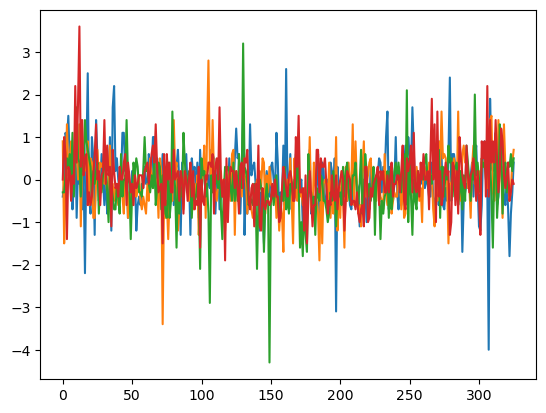

In [137]:
plt.plot(offset['xm1s'][10,:,50])
# plt.plot(offset['xm1s'][10,:,51])
plt.plot(offset['xm1s'][9,:,50])
plt.plot(offset['xm1s'][8,:,50])
plt.plot(offset['xm1s'][7,:,50])

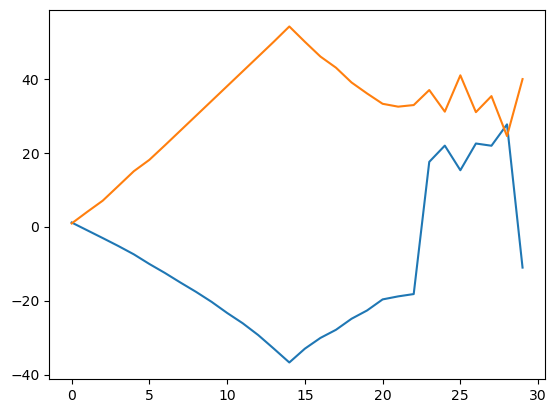

In [127]:
plt.plot(offset['yms'].mean(axis=1))
plt.plot(offset['xms'].mean(axis=1))

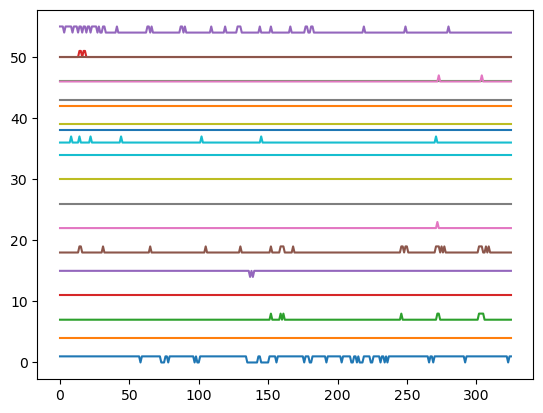

In [122]:
plt.plot(offset['xms'][:20].T)

In [108]:
job.tifs

['/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00001.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00002.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00003.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00004.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00005.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00006.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00007.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00008.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00009.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00010.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00011.tif',
 '/mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREE

In [75]:
job.get_registered_files('registered_data', 'reg_data')

['/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0000.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0001.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0002.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0003.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0004.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0005.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0006.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0007.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0008.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0009.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0010.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_data0011.npy',
 '/mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/registered_data/reg_d